In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import utils
import anchor_tabular

In [2]:

moons_anchor = pickle.load(open('out_pickles/moons-anchor-svm', 'rb'))#, encoding='latin1')
moons_lime = pickle.load(open('out_pickles/moons-lime-svm', 'rb'))#, encoding='latin1')

X, y = make_moons(noise=0.3, random_state=0)
X = StandardScaler().fit_transform(X)
    #X[:, 0] *= 10
X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)


In [3]:
moons_lime['model']

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=2, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [6]:
# Load the dataset (already discretized)
dataset = utils.load_dataset('moons')

In [7]:
exps = moons_lime['exps']
data_exps = dataset.data[moons_lime['validation_idx']]


In [33]:
dataset.feature_names

['x1', 'x2']

In [34]:
dataset.train

array([[2., 1.],
       [3., 1.],
       [2., 0.],
       [1., 1.],
       [3., 2.],
       [0., 3.],
       [3., 2.],
       [3., 1.],
       [2., 3.],
       [0., 2.],
       [3., 0.],
       [0., 1.],
       [1., 2.],
       [3., 2.],
       [3., 1.],
       [3., 1.],
       [0., 1.],
       [1., 2.],
       [2., 0.],
       [1., 2.],
       [1., 1.],
       [0., 3.],
       [3., 2.],
       [0., 3.],
       [0., 2.],
       [2., 0.],
       [2., 3.],
       [0., 2.],
       [2., 2.],
       [0., 2.],
       [0., 1.],
       [1., 1.],
       [0., 1.],
       [2., 0.],
       [1., 3.],
       [2., 1.],
       [1., 1.],
       [2., 2.],
       [1., 1.],
       [3., 2.],
       [2., 1.],
       [0., 3.],
       [1., 3.],
       [0., 1.],
       [0., 3.],
       [2., 1.],
       [1., 2.],
       [2., 3.],
       [1., 3.],
       [3., 0.],
       [0., 2.],
       [2., 3.],
       [0., 3.],
       [1., 0.],
       [2., 0.],
       [1., 0.],
       [3., 3.],
       [2., 2.],
       [1., 1.

In [9]:
#import pickle
import numpy as np
#import matplotlib.pyplot as plt
#from sklearn.datasets import make_moons
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
import utils
import anchor_tabular


# Create the dataset discretized, and the split for test and training are all done inside here
dataset = utils.load_dataset('moons')

# Define the discretizer on the WHOLE data, not just train. It can be done by calling it from the dataset loaded.
disc = dataset.disc

# Define the explainer object that the anchor and lime will use
explainer_obj = anchor_tabular.AnchorTabularExplainer(dataset.class_names, \
                                                          dataset.feature_names, \
                                                          dataset.data, \
                                                          dataset.categorical_names)
explainer_obj.fit(dataset.train, dataset.labels_train, dataset.validation, dataset.labels_validation)


def get_lime_explanation_fn(clf, x_0, disc, explainer_obj):
    """
    Returns a function that takes in a data point (in the ORIGINAL space) that spits out the explanations
    
    params: clf the classifier we want to explain
    params: x_0 the center point
    params: disc the discretization method to use (can be the ones from lime API)
    params: explainer object that is required for lime and anchor explanation
    
    output: a function that takes in a data point (in the ORIGINAL space) that spits out the explanations
    """
   
    x_0_disc = disc.discretize(x_0)
    
    explain_fn = utils.get_reduced_explain_fn(explainer_obj.explain_lime, clf.predict_proba, num_features=5, use_same_dist=True)
    exp = explain_fn(x_0_disc)
    intercept = exp['intercept']
    
    def g(x):
        x_tilde = disc.discretize(x)
        weights = []
        for f in exp['as_map']:
            weights.append(exp['as_map'][f])
        scores = np.dot(x_tilde, np.array(weights)) + intercept
        if scores > 0:
            return 1
        else:
            return 0
    return g
    
    

In [83]:
def get_anchor_explanation_fn(f, x_center, disc, explainer_obj):
    threshold = 0.95
    tau = 0.1
    delta = 0.05
    epsilon_stop = 0.05
    batch_size = 100
    explain_fn = utils.get_reduced_explain_fn(
        explainer_obj.explain_lucb_beam, f.predict, threshold=threshold,
        delta=delta, tau=tau, batch_size=batch_size / 2,
        sample_whole_instances=True,
        beam_size=10, epsilon_stop=epsilon_stop)
    x_center_tilde = disc.discretize(x_center)
    g_tilde = explain_fn(x_center_tilde) #explain_fn = explain_lucb_beam - k=line 254 in anchor_tabular;#g_tilde = anchor_base.AnchorBaseBeam.anchor_beam = exp
    explanations = [g_tilde]
    #print x_center_tilde, x_center
    explanations_data = [x_center_tilde]
    x_center_tilde_onehot = explainer_obj.encoder.transform(x_center_tilde.reshape(-1,2))
    explanation_preds = f.predict(x_center_tilde_onehot)
    print g_tilde
    
    def g(x):
        x_tilde = disc.discretize(x)
        dataset = x_tilde
   
        covered = {}
        for i, (exp, d) in enumerate(zip(explanations, explanations_data)):
            fs = []
            for f, p in zip(exp['feature'], exp['precision']):
                fs.append(f)
                if p >= threshold:
                    break
            fs = np.array(fs)
            covered[i] = set(np.all(dataset[fs] == d[fs]).nonzero()[0])

        votes = []
        for j in covered:
            if i in covered[j]:
                votes.append(explanation_preds[j])
        if votes:
            print votes
            return np.random.choice(votes)
        else:
            return None
    return g

{'names': ['x2 > 0.66', '-0.14 < x1 <= 0.47'], 'feature': [1, 0], 'precision': [0.8235294117647058, 1.0], 'num_preds': 500001, 'examples': [{'covered': array([[2., 3.],
       [2., 3.],
       [2., 3.],
       [1., 3.],
       [2., 3.],
       [3., 3.],
       [2., 3.],
       [2., 3.],
       [2., 3.],
       [2., 3.]]), 'uncovered_true': array([], dtype=float64), 'covered_true': array([[0., 3.],
       [1., 3.],
       [1., 3.],
       [2., 3.],
       [1., 3.],
       [2., 3.],
       [1., 3.],
       [1., 3.],
       [2., 3.],
       [2., 3.]]), 'uncovered_false': array([], dtype=float64), 'covered_false': array([[3., 3.],
       [3., 3.],
       [3., 3.],
       [3., 3.],
       [3., 3.],
       [3., 3.],
       [3., 3.],
       [3., 3.],
       [3., 3.]])}, {'covered': array([[1., 3.],
       [1., 3.],
       [1., 3.],
       [1., 3.],
       [1., 3.],
       [1., 3.],
       [1., 3.],
       [1., 3.],
       [1., 3.],
       [1., 3.]]), 'uncovered_true': array([], dtype=float64)

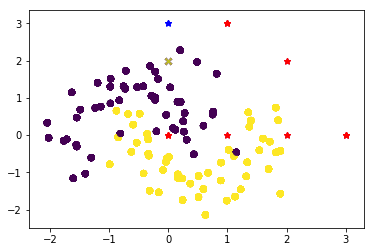

In [84]:
clf = moons_lime['model']
clf = moons_anchor['model']
x_0 = dataset.data[moons_lime['validation_idx'][2]]
#g = get_lime_explanation_fn(clf, x_0, disc, explainer_obj)
g = get_anchor_explanation_fn(clf, x_0, disc, explainer_obj)

for i in moons_lime['test_idx']:
    test_point = dataset.data[i]
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.scatter(x_0[0], x_0[1], marker='x')
    correct = g(test_point) == dataset.labels[i]
    if correct:
        plt.scatter(test_point[0], test_point[1], marker='*', c='b')
    else:
        plt.scatter(test_point[0], test_point[1], marker='*', c='r')
        
plt.show()
    